In [5]:
# Import necessary libraries
import pennylane as qml # type: ignore
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pennylane as qml
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


Epoch 10/50, Loss: 0.4695
Epoch 20/50, Loss: 0.4592
Epoch 30/50, Loss: 0.4571
Epoch 40/50, Loss: 0.4563
Epoch 50/50, Loss: 0.4560


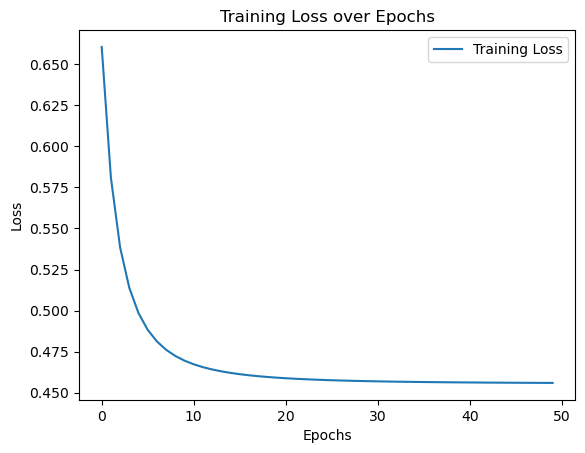

Training Data Evaluation:
Accuracy: 0.7975
Precision: 0.7838
Recall: 0.8722
F1 Score: 0.8256

Testing Data Evaluation:
Accuracy: 0.7213
Precision: 0.7586
Recall: 0.6875
F1 Score: 0.7213


In [6]:
# Import necessary libraries
import pennylane as qml
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Function to load and preprocess data, including categorical features
def load_data(csv_path):
    # Load data from CSV
    data = pd.read_csv(csv_path)
    X = data.drop(columns=['output'])  # Assume target column is named 'output'
    y = data['output'].values

    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
    
    # Create a ColumnTransformer to process categorical and numerical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(), categorical_cols)
        ]
    )

    # Fit and transform the features
    X_processed = preprocessor.fit_transform(X)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, X_processed.shape[1]

# Define the quantum circuit with parameterized rotations based on features
def create_quantum_device(n_qubits):
    return qml.device("default.qubit", wires=n_qubits)

# Define quantum circuit to handle each feature in separate qubits
def create_quantum_circuit(dev, n_features):
    @qml.qnode(dev, interface="torch")
    def quantum_circuit(features, theta):
        for i in range(n_features):
            qml.RY(features[i], wires=i)
            qml.RY(theta[i], wires=i)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_features)]
    return quantum_circuit

# Define Quantum Neural Network Layer for multiple features
class QNNLayer(nn.Module):
    def __init__(self, n_features):
        super(QNNLayer, self).__init__()
        self.theta = nn.Parameter(torch.tensor([0.1] * n_features, dtype=torch.float32, requires_grad=True))
        self.n_features = n_features
        self.dev = create_quantum_device(n_features)
        self.quantum_circuit = create_quantum_circuit(self.dev, n_features)
    
    def forward(self, x):
        x = x.to(torch.float32)
        output = torch.tensor(self.quantum_circuit(x, self.theta))
        return output

# Define full Quantum Neural Network model with multiple features
class QNN(nn.Module):
    def __init__(self, n_features):
        super(QNN, self).__init__()
        self.qnn_layer = QNNLayer(n_features)
        self.fc_layer = nn.Linear(n_features, 1, dtype=torch.float32)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Pass the data through the QNN layer
        qnn_output = self.qnn_layer(x)
        
        # Ensure qnn_output is float32 before passing to the fully connected layer
        qnn_output = qnn_output.to(torch.float32)
        
        # Fully connected layer and activation
        output = self.sigmoid(self.fc_layer(qnn_output))
        return output


# Training function for the QNN with binary cross-entropy loss
def train_qnn(model, data, targets, epochs=50, lr=0.01):
    optimizer = Adam(model.parameters(), lr=lr)
    loss_func = nn.BCELoss()  # Binary Cross-Entropy Loss
    losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for x, y in zip(data, targets):
            optimizer.zero_grad()
            
            # Ensure inputs and target are float32
            x_tensor = torch.tensor(x, dtype=torch.float32)
            y_tensor = torch.tensor([y], dtype=torch.float32)
            
            # Forward pass
            prediction = model(x_tensor)
            
            # Calculate loss
            loss = loss_func(prediction, y_tensor)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(data)
        losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    plt.plot(range(epochs), losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    plt.show()
    
    return losses


# Evaluation function
def evaluate_qnn(model, data, targets, threshold=0.5):
    model.eval()
    predictions = []
    binary_predictions = []
    with torch.no_grad():
        for x in data:
            prediction = model(torch.tensor(x, dtype=torch.float32)).item()
            predictions.append(prediction)
            binary_predictions.append(1 if prediction >= threshold else 0)
    
    accuracy = accuracy_score(targets, binary_predictions)
    precision = precision_score(targets, binary_predictions)
    recall = recall_score(targets, binary_predictions)
    f1 = f1_score(targets, binary_predictions)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Load data from CSV, including categorical processing
csv_path = 'heart.csv'  # Path to your CSV file
X_train, X_test, y_train, y_test, n_features = load_data(csv_path)

# Initialize and train QNN with number of features (including categorical one-hot encoded)
qnn = QNN(n_features)
train_qnn(qnn, X_train, y_train, epochs=50, lr=0.01)

# Evaluate the model
print("Training Data Evaluation:")
evaluate_qnn(qnn, X_train, y_train)
print("\nTesting Data Evaluation:")
evaluate_qnn(qnn, X_test, y_test)
